In [9]:
%matplotlib inline


# Rakip Örnek Oluşturma

## Tehdit Modeli
Bir *beyaz kutu* saldırısında,saldırganın, aşağıdakiler de dahil olmak üzere modele ilişkin tam bilgisi ve erişimi vardır.
Mimari, girdiler, çıktılar ve ağırlıklar. Bir *kara kutu* saldırısı saldırganın yalnızca modelin giriş ve çıkışlarına erişimi vardır ve
altta yatan mimari veya ağırlıklar hakkında hiçbir şey bilmediğini varsayar.
*yanlış sınıflandırma* hedefi şu anlama gelir: düşman yalnızca çıktı sınıflandırmasının yanlış olmasını ister, ancak
yeni sınıflandırmanın ne olduğu ile ilgilenmez. *kaynak/hedef
yanlış sınıflandırma*, rakibin bir görüntüyü değiştirmek istediği anlamına gelir.
Bu durumda FGSM saldırısı, amacı olan bir *beyaz kutu* saldırısıdır.

## Fast Gradient Sign Attack

Bugüne kadarki ilk ve en popüler hasım saldırılarından biri
*Hızlı Gradyan İşaret Saldırısı (FGSM)* olarak anılır ve açıklanır
(GAN'ların mucidi Ian Goodfellow tarafından böyle tabir ediliyor.)(https://arxiv.org/abs/1412.6572)
Sinir ağlarına saldırmak için tasarlanmıştır. Gradyanların öğrenme şekillerindeny yararlanmaya çalışır.Saldırı yöntemi, giriş verisi ile kayıp gradyanını kullanır, ardından
kaybı en üst düzeye çıkarmak için giriş verilerini ayarlar.


In [10]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt

# NOT: Bu, MNIST veri kümelerini indirirken "Kullanıcı aracısı" sınırlamalarını aşmak için bir saldırıdır
# daha fazla bilgi için bkz. https://github.com/pytorch/vision/issues/3497
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

## uygulama

Bu bölümde, öğretici için giriş parametrelerini tartışacağız,
saldırı altındaki modeli tanımlayın, ardından saldırıyı kodlayın ve bazı testler yapın.

### Inputs

üç giriş vardır ve şu şekilde tanımlanır:

- **epsilons** - Çalışma için kullanılacak epsilon değerlerinin listesi. Bu
    modeli temsil ettiği için 0'ı listede tutmak önemlidir Ayrıca, sezgisel    olarak
    epsilon ne kadar büyük olursa bozulmalar o kadar belirgin olur
    ancak aşağılayıcı model açısından saldırı daha etkili. Buradaki veri aralığı [0,1] olduğu için epsilon yok
    değer 1'i geçmelidir.

- **pretrained_model** - önceden eğitilmiş MNIST modeli
    [pytorch/examples/mnist](https://github.com/pytorch/examples/tree/master/mnist)_.
    Basit olması için önceden eğitilmiş modeli [buradan](https://drive.google.com/drive/folders/1fn83DF14tWmit0RTKWRhPq5uVXt73e0h?usp=sharing)_ indirin.

- **use_cuda** - istenirse ve mevcutsa CUDA'yı kullanmak için
    CUDA'lı bir GPU'nun bu eğitim için kritik olmadığını unutmayın;
    fazla zaman almaz.




In [12]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
pretrained_model = "/data/lenet_mnist_model.pth"
use_cuda=True

### Saldırı Altındaki Model

Belirtildiği gibi, saldırı altındaki model, MNIST modelinin aynısıdır.
[pytorch/examples/mnist](https://github.com/pytorch/examples/tree/master/mnist)_.
Kendi MNIST modelinizi eğitebilir ve kaydedebilir veya indirip kullanabilirsiniz.

Buradaki *Net* tanımı ve test veri yükleyicisi,
MNIST örneğinden kopyalanmıştır. Bu bölümün amacı,
modeli ve veri yükleyiciyi tanımlayın, ardından modeli önceden eğitilmiş ağırlıklar ile başlatın.




In [13]:
# LeNet Model tanımlayalım.
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# MNIST Test dataset ve dataloader 
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])), 
        batch_size=1, shuffle=True)

# varsa cuda kullanacağız
print("CUDA Durumu: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

# modelimizi başlatalım
model = Net().to(device)

# önceden eğitilmiş modelimizi yükleyelim
model.load_state_dict(torch.load(pretrained_model, map_location='cpu'))

# modelimizi değerlendirme moduna alalım.
model.eval()

CUDA Durumu:  False


Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

### FGSM Atak

Şimdi, rakip örnekleri oluşturan fonksiyonu parametreleri şu şekilde tanımlayabiliriz:
Orjinal girdileri bozarak. ``fgsm_attack`` fonksiyonunda
*image* orijinal temiz görüntüdür ($x$), *epsilon*
piksel bazında tedirginlik miktarı ($\epsilon$) ve *data_grad*
giriş görüntüsü ile kaybın gradyanı

($\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y)$. İşlev
sonra fake görüntü oluşturur

\begin{align}perturbed\_image = image + epsilon*sign(data\_grad) = x + \epsilon * sign(\nabla_{x} J(\mathbf{\theta}, \mathbf{x}, y))\end{align}

Son olarak, verilerin orijinal aralığını korumak için,
fake görüntü $[0,1]$ aralığına kırpılır.




In [14]:
# FGSM atak.
def fgsm_attack(image, epsilon, data_grad):
    # gradyan verilerinin eleman bazında işaretlerini toplayalım.
    sign_data_grad = data_grad.sign()
    # Girdi görüntüsünün her pikselini ayarlayarak fake görüntüyü oluşturalım.
    perturbed_image = image + epsilon*sign_data_grad
    # [0,1] aralığını korumak için kırpmayı ekleyelim.
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # üretilen fake görüntüyü döndürelim.
    return perturbed_image

### Test Fonksiyonu

In [15]:
def test( model, device, test_loader, epsilon ):

    # acc
    correct = 0
    adv_examples = []

    # Test setindeki tüm örnekler üzerinde döngü yapın
    for data, target in test_loader:

        # verileri gpu ya aktaralım.
        data, target = data.to(device), target.to(device)

        # Tensörün request_grad niteliğini ayarlayın. Saldırı için önemli.
        data.requires_grad = True

        # Verileri model üzerinden iletin
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # maksimum günlük olasılığının dizinini al

        # İlk tahmin yanlışsa, saldırmaya gerek yok, devam edelim.
        if init_pred.item() != target.item():
            continue

        # kaybı hesaplayalım
        loss = F.nll_loss(output, target)

        # Mevcut tüm gradyanları sıfırlayın
        model.zero_grad()

        # backpro yapalım
        loss.backward()

        # Veri toplama
        data_grad = data.grad.data

        # fgsm_attack fonksiyonunu çağıralım
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # fake görüntüyü yeniden sınıflandırın
        output = model(perturbed_data)

        # başarımı kontrol edelim.
        final_pred = output.max(1, keepdim=True)[1] # maksimum günlük olasılığının dizinini al
        if final_pred.item() == target.item():
            correct += 1
            # 0 epsilon örneği kaydetmek için özel durum
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            # Daha sonra görselleştirme için bazı örneklerini kaydedin
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Bu epsilon için nihai doğruluğu hesaplayın
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Doğruluğu ve fake bir örneği döndürün
    return final_acc, adv_examples

### Saldırıyı çalıştır

Uygulamanın son kısmı, saldırıyı fiilen çalıştırmaktır. Burada,
*epsilons* girişindeki her epsilon değeri için tam bir test adımı uyguluyoruz.
Her epsilon için son doğruluğu ve bazı başarılı sonuçları da kaydediyoruz.
Gelecek bölümlerde çizilecek düşmanca örnekler için. Epsilon değeri arttıkça yazdırılan doğruluklar azalır. Ayrıca,
$\epsilon=0$ durumunun saldırı olmadan orijinal test doğruluğunu temsil ettiğini unutmayın





In [16]:
accuracies = []
examples = []

# Her epsilon için test çalıştırın
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

Epsilon: 0	Test Accuracy = 9810 / 10000 = 0.981
Epsilon: 0.05	Test Accuracy = 9426 / 10000 = 0.9426
Epsilon: 0.1	Test Accuracy = 8510 / 10000 = 0.851
Epsilon: 0.15	Test Accuracy = 6826 / 10000 = 0.6826
Epsilon: 0.2	Test Accuracy = 4301 / 10000 = 0.4301
Epsilon: 0.25	Test Accuracy = 2082 / 10000 = 0.2082
Epsilon: 0.3	Test Accuracy = 869 / 10000 = 0.0869


## Sonuçlar

### Accuracy vs Epsilon

İlk sonuç, epsilon grafiğine karşı doğruluktur. ima edildiği gibi
daha önce, epsilon arttıkça test doğruluğunun düşmesini bekliyoruz.
Bunun nedeni, daha büyük epsilonların daha büyük bir adım attığımız anlamına gelmesidir.




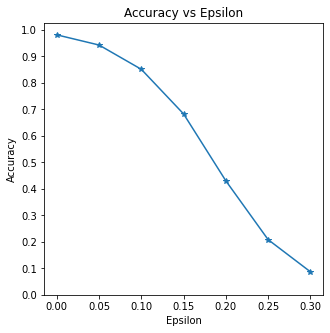

In [17]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

### Örnek Düşman Örnekleri

Epsilon arttıkça test doğruluğu azalır. **AMA** bozulmalar daha kolay hale gelir.Bir saldırganın göz önünde bulundurması gereken bozulma ve algılanabilirliktir.




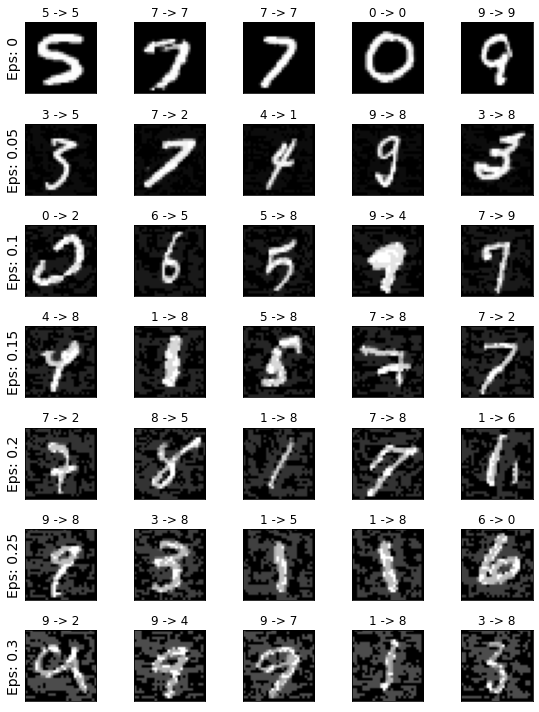

In [18]:
# Her bir epsilonda birkaç rakip örnek örneği çizdirelim.
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

## öneri
(https://arxiv.org/pdf/1804.00097.pdf) ve (https://arxiv.org/pdf/1801.01944.pdf) makaleye göz atın


